# АНСАМБЛИ МОДЕЛЕЙ

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#устраним ошибки со шрифтами
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

# Часть 1. Бэггинг

## Описание задачи

Используем данные страхового подразделения BNP Paribas из соревнования

https://www.kaggle.com/c/bnp-paribas-cardif-claims-management

Решается задача классификации страховых случаев:
    1. Случаи, требующие дополнительных документов для подтвердения (0)
    2. Случаи, которые можно подтверждать автоматически на основе имеющейся информации (1)

## Загрузка данных

In [2]:
data = pd.read_csv('datasets/ensembles/train.csv')

data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


Уменьшим размер данных для ускорения обучения, возмем случайную подвыборку 20% данных со стратификацией

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

Разбиение на обучение и hold-out тест 70/30. Данных досттаточно много, поэтому можно принебречь честной кросс-валидацией и оценивать модель
на тесте

In [4]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=.3, random_state=777)

for train_index, test_index in splitter.split(data, data.target):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

## Первичный анализ

Размер датасета

In [5]:
data.shape

(22865, 133)

Распределение значений таргета (event rate)

In [6]:
data.target.value_counts()/len(data)

1    0.761207
0    0.238793
Name: target, dtype: float64

## Предобработка данных

Находим категориальные признаки

Чтобы в разы не увеличивать число признаков при построении dummi, будем использовать категориальные
признаки с < 30 уникальных значений

In [7]:
data.dtypes.head(50)

ID          int64
target      int64
v1        float64
v2        float64
v3         object
v4        float64
v5        float64
v6        float64
v7        float64
v8        float64
v9        float64
v10       float64
v11       float64
v12       float64
v13       float64
v14       float64
v15       float64
v16       float64
v17       float64
v18       float64
v19       float64
v20       float64
v21       float64
v22        object
v23       float64
v24        object
v25       float64
v26       float64
v27       float64
v28       float64
v29       float64
v30        object
v31        object
v32       float64
v33       float64
v34       float64
v35       float64
v36       float64
v37       float64
v38         int64
v39       float64
v40       float64
v41       float64
v42       float64
v43       float64
v44       float64
v45       float64
v46       float64
v47        object
v48       float64
dtype: object

In [8]:
cat_feat = list(data.dtypes[data.dtypes == object].index)

# закодируем пропущенные знаения строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

# отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)
cat_feat = list(cat_nunique[cat_nunique < 30].index)

v3         3
v22     6610
v24        5
v30        7
v31        3
v47        9
v52       12
v56       90
v66        3
v71        5
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      22
v113      34
v125      88
dtype: int64


In [9]:
from sklearn.metrics import auc, roc_curve
from sklearn.linear_model import LogisticRegression

## Композиция моделей одного семейства

### Будем использовать решеющие деревья

1. Неустойчивы к входным данным
2. Склонны к переобучению
3. Быстро обучаются

=> отличный выбор для построения композиций

**Создаем признаки для "деревянных" моделей**

1. Заменяем пропуски на специальны значения -999, чтобы деревья могли их отличить
2. Создаем дамми-переменный для категорий

In [10]:
dummi_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummi_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummi_cols = list(set(dummi_train) & set(dummi_test))

dummi_train = dummi_train[dummi_cols]
dummi_test = dummi_test[dummi_cols]

X_train = pd.concat([d_train[num_feat].fillna(-999), dummi_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999), dummi_test], axis=1)

Обучаем решающее дерево

Немного ограничим глубину и минимальное количество объектов в листе для уменьшения переобучения

In [11]:
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

In [12]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)

#### Считаем ROS AUC

In [13]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print(f'ROC AUC: {auc_val:.4f}')
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

Предсказываем  вероятность класса 1 и считаем ROC AUC

Train
ROC AUC: 0.8591
Test
ROC AUC: 0.6458


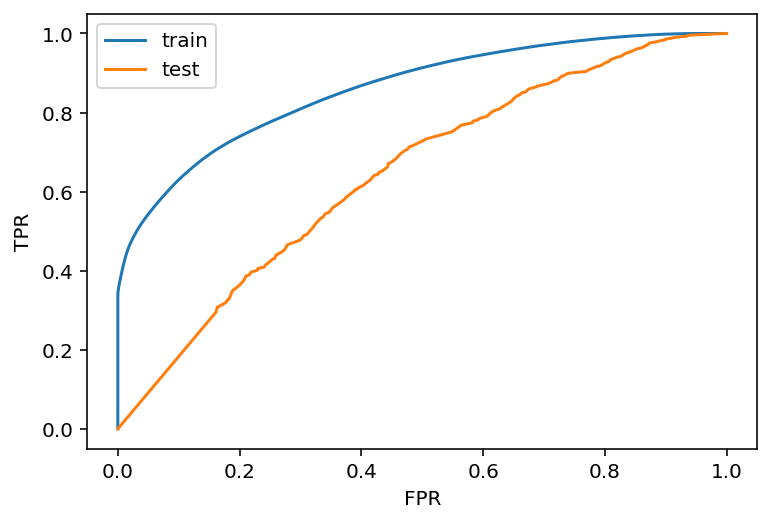

In [14]:
y_pred_test = clf_tree.predict_proba(X_test)[:, 1]
y_pred_train = clf_tree.predict_proba(X_train)[:, 1]

print('Train')
calc_auc(y_train, y_pred_train, 'train')
print('Test')
calc_auc(y_test, y_pred_test, 'test')
plt.legend();

### Бэггинг

In [15]:
import numpy as np

In [16]:
np.arange(y_train.shape[0])

array([    0,     1,     2, ..., 16002, 16003, 16004])

In [17]:
BAGGING_ITERS = 20

y_pred_test = np.zeros_like(y_pred_test)
y_pred_train = np.zeros_like(y_pred_train)

for i in tqdm.trange(BAGGING_ITERS):
    new_index = np.random.choice(np.arange(y_train.shape[0]), size=y_train.shape[0], replace=True)
    clf_tree.fit(X_train.iloc[new_index], y_train.iloc[new_index])
    
    y_pred_test += clf_tree.predict_proba(X_test)[:, 1]
    y_pred_train += clf_tree.predict_proba(X_train)[:, 1]

y_pred_test /= BAGGING_ITERS
y_pred_train /= BAGGING_ITERS

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]


Train
ROC AUC: 0.9174
Test
ROC AUC: 0.7203


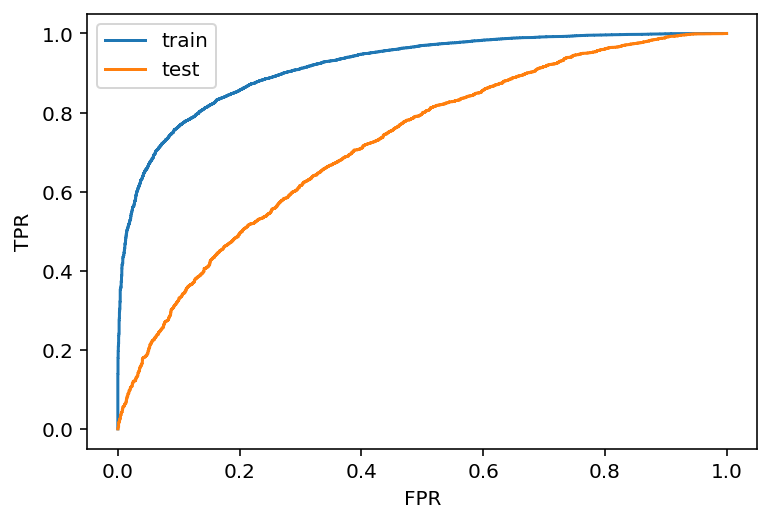

In [18]:
print('Train')
calc_auc(y_train, y_pred_train, 'train')
print('Test')
calc_auc(y_test, y_pred_test, 'test')
plt.legend();

### Бэггинг

Используем готовый алгоритм из sklearn

In [19]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(n_estimators=20, base_estimator=clf_tree, n_jobs=-1)

%time bag_clf.fit(X_train, y_train)

y_pred_test = bag_clf.predict_proba(X_test)[:, 1]
y_pred_train = bag_clf.predict_proba(X_train)[:, 1]

Wall time: 9.95 s


Train
ROC AUC: 0.8904
Test
ROC AUC: 0.7187


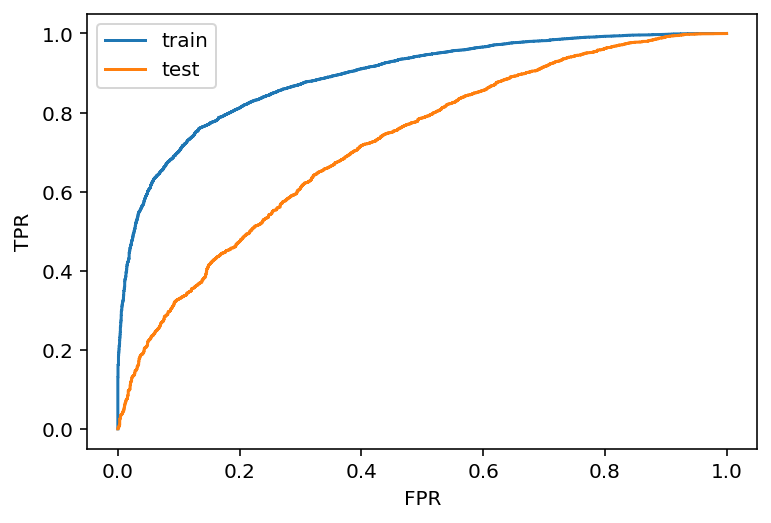

In [20]:
print('Train')
calc_auc(y_train, y_pred_train, 'train')
print('Test')
calc_auc(y_test, y_pred_test, 'test')
plt.legend();

# Часть 2. Случайный лес

Бэггинг + случайные подпространства = случайный лес

**Важные гиперпараметры алгоритма**

а. Параметры деревьев
    1. criterion - критерий построения дерева
    2. max_dept - максимальная глубина дерева(обычно 10-20, больше глубина -> больше риск переобучения)
    3. min_samples_leaf - минимальное число объектов в листе (обычно 20+, больше объектов -> меньше
                                                             риск переобучения)
b. Параметры леса
    1. n_estimators - количество деревьев (чем больше, тем лучше)
    2. max_features - число признаков случайного подпространства
    3. bootstrap - использовать ли бэггинг
    4. n_jobs - количество потоков для одновременного построения деревьев (большая прибавка к скорости на
                                                                           многоядерных процессарах)

In [21]:
'минимальное число объектов в листе'.upper()

'МИНИМАЛЬНОЕ ЧИСЛО ОБЪЕКТОВ В ЛИСТЕ'

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_leaf=20, max_features=.8, n_jobs=-1)

%time clf_rf.fit(X_train, y_train)

Wall time: 31.7 s


RandomForestClassifier(max_depth=15, max_features=0.8, min_samples_leaf=20,
                       n_estimators=300, n_jobs=-1)

Train
ROC AUC: 0.9005
Test
ROC AUC: 0.7265


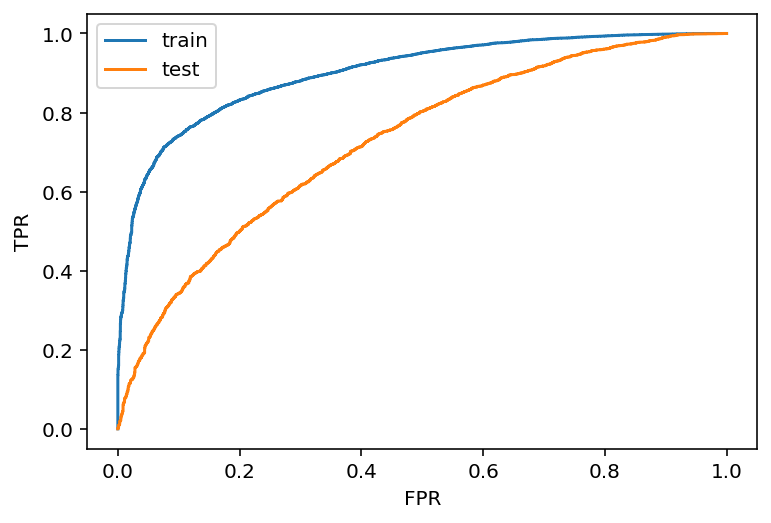

In [23]:
y_pred_rf_test = clf_rf.predict_proba(X_test)[:, 1]
y_pred_rf_train = clf_rf.predict_proba(X_train)[:, 1]

print('Train')
calc_auc(y_train, y_pred_rf_train, 'train')
print('Test')
calc_auc(y_test, y_pred_rf_test, 'test')
plt.legend();

#### Важность признаков

В sklearn - усредненное по всем деревьям в ансамбле колчество сплитов по признаку, взвешенное на прирост
информации (information gain) и долю объектов в вершине, в которой производится этот сплит

это не единственный вариант, см. здесь:

https://medium.com/@ceshine/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

Важность признаков случайного леса лежат в атрибуте **feature\_importances\_**

In [25]:
imp = pd.Series(clf_rf.feature_importances_, X_train.columns)
imp.sort_values(ascending=False)

v50       0.269583
v66_C     0.040402
v21       0.033791
v110_A    0.031294
v12       0.030330
            ...   
v47_B     0.000000
v75_A     0.000000
v47_A     0.000000
v112_S    0.000000
v30_B     0.000000
Length: 219, dtype: float64

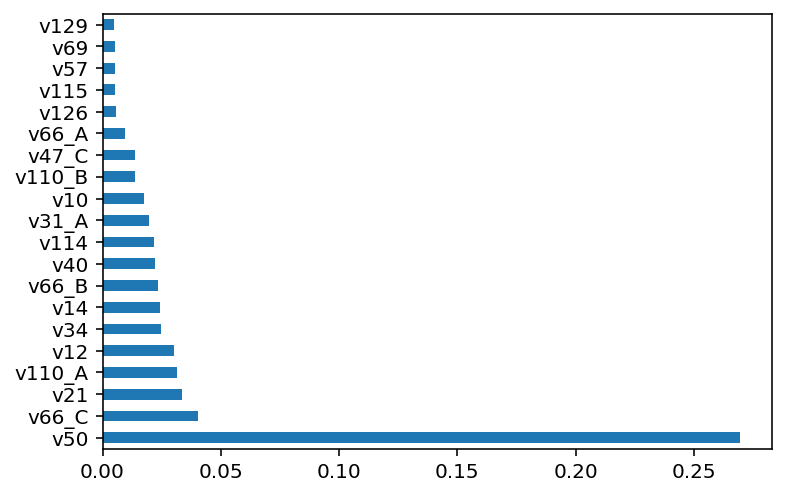

In [61]:
imp.sort_values(ascending=False).iloc[:20].plot(kind='barh');

# Часть 3. Композиции моделей разных типов

### Линейная комбинация моделей разного типа

Смешаем дерево и логистическую регрессию

**Создадим признаки для логистической регрессии**

1. Заменяем пропуски на медианы
2. Создаем индикаторы пропущенных значений
3. Создаём дамми-переменные для категорий